# Random Forest: Classification Example
The purpose of this notebook is to practice training, predicting and evaluating a classification technique named Random Forest (RF).
We will use the Python packages: pandas, matplotlib and scikit-learn.
Besides the material presented in this notebook, please also read this [notebook](https://github.com/justmarkham/DAT4/blob/master/notebooks/16_ensembling.ipynb) that gives another example of using  random forest with scikit-learn. This [notebook](https://github.com/justmarkham/DAT4/blob/master/notebooks/15_decision_trees.ipynb) discusses another example of using decision tree models.

In classification the aim is to classify an example into one of many classes. 
RandomForest can directly work with many classes, 
without the need to turn the problem into many one-vs-all problems.

In classification, we interpret the target feature as the probability of class membership:
$probability(target=1|descriptive\_features)$

For a single decision tree this probability is estimated as: the proportion of examples from the positive class, 
at the leaf node that contains our test example.
So if our test example ends up in a leaf node with 10 other examples, and 8 out of 10 examples are in class 1, 
then the probability $probability(target=1|descriptive\_features) = \frac{8}{10} = 0.8$.

For RF this probability is estimated (see [documentation](http://scikit-learn.org/dev/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.predict_proba)) as the mean predicted class probabilities of the trees in the forest. 

So for example if we use 3 trees, with probability for class 1 on given example being 0.5, 0.6 and 0.7, 
then the probability $probability(target=1|descriptive\_features) = \frac{0.5 + 0.6 + 0.7}{3} = 0.6$.


## Reading data

In [83]:
# Read into a dataframe a CSV dataset with 10 example offices 
# described by 5 features (4 descriptive features: Size, Floor, BroadbandRate, EnergyRating;
# the target feature: RentalPrice).

# Import required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from patsy import dmatrices

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score 

from sklearn.tree import export_graphviz
import graphviz
from graphviz import Source

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Allows plots to appear directly in the notebook.
%matplotlib inline

In [84]:
# Read csv file into a dataframe.
df = pd.read_csv('Offices.csv')
df

,ID,Size,Floor,BroadbandRate,EnergyRating,RentalPrice
0,1,500,4,8,C,320
1,2,550,7,50,A,380
2,3,620,9,7,A,400
3,4,630,5,24,B,390
4,5,665,8,100,C,385
5,6,700,4,8,B,410
6,7,770,10,7,B,480
7,8,880,12,50,A,600
8,9,920,14,8,C,570
9,10,1000,9,24,B,620


In [85]:
# Print the average RentalPrice in our dataset.
# We could use this as a very simple baseline prediction model.
# A smarter prediction model should at least improve on this baseline model.
df.RentalPrice.mean()

455.5

In [86]:
# Transform the target feature RentalPrice into a categorical feature named PriceClass. 
# Map the prices higher than the average RentalPrice to category High, remaining prices to category Low.
PriceClass = (df.RentalPrice > 455.5) * 1.0
#PriceClass
df_PriceClass = pd.DataFrame({'PriceClass': PriceClass})
df_PriceClass

,PriceClass
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
5,0.0
6,1.0
7,1.0
8,1.0
9,1.0


In [87]:
# Crate a new dataframe where we add column PriceClass to the original dataframe with 10 offices.
df_classif = pd.concat([df, df_PriceClass], axis = 1)
df_classif

,ID,Size,Floor,BroadbandRate,EnergyRating,RentalPrice,PriceClass
0,1,500,4,8,C,320,0.0
1,2,550,7,50,A,380,0.0
2,3,620,9,7,A,400,0.0
3,4,630,5,24,B,390,0.0
4,5,665,8,100,C,385,0.0
5,6,700,4,8,B,410,0.0
6,7,770,10,7,B,480,1.0
7,8,880,12,50,A,600,1.0
8,9,920,14,8,C,570,1.0
9,10,1000,9,24,B,620,1.0


In [88]:
# Drop the column RentalPrice from the df_classif dataframe.
df_classif.drop('RentalPrice', axis=1, inplace=True)
df_classif

,ID,Size,Floor,BroadbandRate,EnergyRating,PriceClass
0,1,500,4,8,C,0.0
1,2,550,7,50,A,0.0
2,3,620,9,7,A,0.0
3,4,630,5,24,B,0.0
4,5,665,8,100,C,0.0
5,6,700,4,8,B,0.0
6,7,770,10,7,B,1.0
7,8,880,12,50,A,1.0
8,9,920,14,8,C,1.0
9,10,1000,9,24,B,1.0


In [89]:
# Print the feature types in our dataset.
df_classif.dtypes

ID                 int64
Size               int64
Floor              int64
BroadbandRate      int64
EnergyRating      object
PriceClass       float64
dtype: object

In [90]:
df_classif['EnergyRating'] = df_classif['EnergyRating'].astype('category')
df_classif.dtypes

ID                  int64
Size                int64
Floor               int64
BroadbandRate       int64
EnergyRating     category
PriceClass        float64
dtype: object

## Understanding data

In [91]:
# Look at correlations for all the continuous features.
df_classif[['Size', 'Floor', 'BroadbandRate', 'PriceClass']].corr()

,Size,Floor,BroadbandRate,PriceClass
Size,1.000000,0.710863,-0.069117,0.881208
Floor,0.710863,1.000000,0.054897,0.789086
BroadbandRate,-0.069117,0.054897,1.000000,-0.180374
PriceClass,0.881208,0.789086,-0.180374,1.000000


In [92]:
# The correlation for a given pair of features
df_classif[['Size', 'PriceClass']].corr().as_matrix()[0,1]

/Users/georgianaifrim/anaconda3/envs/comp47350py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


0.88120839967771

/Users/georgianaifrim/anaconda3/envs/comp47350py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


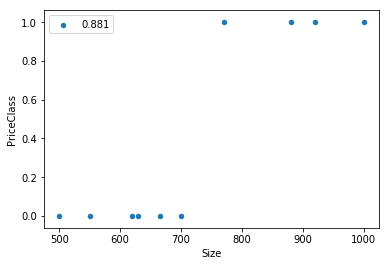

In [93]:
df_classif.plot(kind='scatter', x='Size', y='PriceClass', label="%.3f" % df_classif[['Size', 'PriceClass']].corr().as_matrix()[0,1])

/Users/georgianaifrim/anaconda3/envs/comp47350py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
/Users/georgianaifrim/anaconda3/envs/comp47350py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
/Users/georgianaifrim/anaconda3/envs/comp47350py37/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


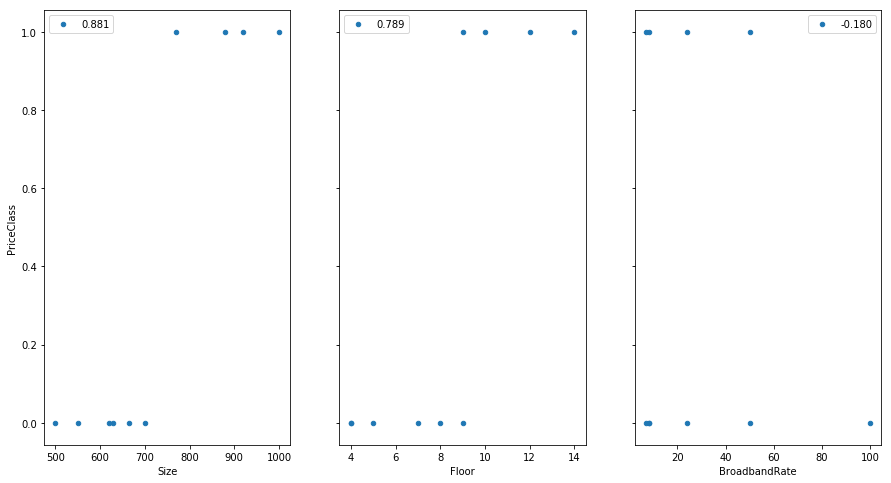

In [94]:
# Scatterplots for each descriptive feature and target feature. 
# Show the correlation value in the plot.
fig, axs = plt.subplots(1, 3, sharey=True)
df_classif.plot(kind='scatter', x='Size', y='PriceClass', label="%.3f" % df_classif[['Size', 'PriceClass']].corr().as_matrix()[0,1], ax=axs[0], figsize=(15, 8))
df_classif.plot(kind='scatter', x='Floor', y='PriceClass', label="%.3f" % df_classif[['Floor', 'PriceClass']].corr().as_matrix()[0,1], ax=axs[1])
df_classif.plot(kind='scatter', x='BroadbandRate', y='PriceClass', label="%.3f" % df_classif[['BroadbandRate', 'PriceClass']].corr().as_matrix()[0,1], ax=axs[2])

We note that feature Size splits the dataset into examples with PriceClass 0 (if Size <= 700) and examples with PriceClass 1 (if Size > 700). We expect that this split should be captured by a decision tree model.

# Decision Tree Classifier package <span style="color:red">scikit-learn</span>


## Prepare input and output data

Prepare the input features X and the target outcome feature y. We do not need an intercept term for decision trees.

In [95]:
# Prepare the data, turn categorical feature EnergyRating into dummies.

df_cont_feat = df_classif[['Size', 'Floor', 'BroadbandRate']]
df_dummies_energyrating = pd.get_dummies(df_classif[['EnergyRating']])
df_dummies_energyrating.head()

,EnergyRating_A,EnergyRating_B,EnergyRating_C
0,0,0,1
1,1,0,0
2,1,0,0
3,0,1,0
4,0,0,1


In [96]:
# Add dummies to the other continuous features
X = pd.concat([df_cont_feat, df_dummies_energyrating[['EnergyRating_B', 'EnergyRating_C']]], axis =1)
y = df_classif.PriceClass
print("Descriptive features:\n", X)
print("\nTarget feature:\n", y)

Descriptive features:
    Size  Floor  BroadbandRate  EnergyRating_B  EnergyRating_C
0   500      4              8               0               1
1   550      7             50               0               0
2   620      9              7               0               0
3   630      5             24               1               0
4   665      8            100               0               1
5   700      4              8               1               0
6   770     10              7               1               0
7   880     12             50               0               0
8   920     14              8               0               1
9  1000      9             24               1               0

Target feature:
 0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
6    1.0
7    1.0
8    1.0
9    1.0
Name: PriceClass, dtype: float64


## Train a decision tree classifier model

In [97]:
# Instantiate sklearn estimator, fit with training set.
# Train a classification tree with max_depth=3 on all data.
dtc = DecisionTreeClassifier(max_depth=3, random_state=1)
dtc.fit(X, y)
print(dtc)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')


In [98]:
# Check the type of this object
type(dtc)

sklearn.tree.tree.DecisionTreeClassifier

## Feature importance from the DTC model

In [99]:
# Compute the importance of each feature based on the trained decision tree classifier
pd.DataFrame({'feature': X.columns, 'importance': dtc.feature_importances_})

,feature,importance
0,Size,1.0
1,Floor,0.0
2,BroadbandRate,0.0
3,EnergyRating_B,0.0
4,EnergyRating_C,0.0


In [100]:
# create a Graphviz file which has extension .dot
with open("Offices.dot", 'w') as f:
    f = export_graphviz(dtc, out_file=f, feature_names=X.columns)

# To look at the tree you need to install the "dot" utility for your operating system
# Once "dot" is installed, at the command line, run this to convert to PNG:
# dot -Tpng Offices.dot -o Offices.png

# If you cannot install the dot utility on your system, look at the alternative option below

In [101]:
path = './Offices.dot'
s = Source.from_file(path)
s.view()

'./Offices.dot.pdf'

In [102]:
# Alternative to print a tree in text format
"""
treeviz.py

A simple tree visualizer for sklearn DecisionTreeClassifiers.

Written by Lutz Hamel, (c) 2017 - Univeristy of Rhode Island
"""
import operator

def tree_print(clf, X):
    """
    Print the tree of a sklearn DecisionTreeClassifier

    Parameters
    ----------
    clf : DecisionTreeClassifier - A tree that has already been fit.
    X : The original training set
    """
    tlevel = _tree_rprint('', clf, X.columns, clf.classes_)
    print('<',end='')
    for i in range(3*tlevel - 2):
        print('-',end='')
    print('>')
    print('Tree Depth: ',tlevel)

def _tree_rprint(kword, clf, features, labels, node_index=0, tlevel_index=0):
    # Note: The DecisionTreeClassifier uses the Tree structure defined in:
    # 		github.com/scikit-learn/scikit-learn/blob/master/sklearn/tree/_tree.pyx
    #       it is an array based tree implementation:

    # indent the nodes according to their tree level
    for i in range(tlevel_index):
        print('  |',end='')

	#  TODO: the following should use the TREE_LEAF constant defined in _tree.pyx
	#        instead of -1, not quite sure how to get at it from the tree user level
    if clf.tree_.children_left[node_index] == -1:  # indicates leaf
        print(kword, end=' ' if kword else '')
        # get the majority label
        count_list = clf.tree_.value[node_index, 0]
        max_index, max_value = max(enumerate(count_list), key=operator.itemgetter(1))
        max_label = labels[max_index]
        print(max_label)
        return tlevel_index
    
    else:
        # compute and print node label
        feature = features[clf.tree_.feature[node_index]]
        threshold = clf.tree_.threshold[node_index]
        print(kword, end=' ' if kword else '')
        print('if {} =< {}: '.format(feature, threshold))
        # recurse down the children
        left_index = clf.tree_.children_left[node_index]
        right_index = clf.tree_.children_right[node_index]
        ltlevel_index = _tree_rprint('then', clf, features, labels, left_index, tlevel_index+1)
        rtlevel_index = _tree_rprint('else', clf, features, labels, right_index, tlevel_index+1)
        # return the maximum depth of either one of the children
        return max(ltlevel_index,rtlevel_index)

In [37]:
# Use the function tree_print defined above to plot a decision tree in text format
tree_print(dtc, X)

if Size =< 700.0: 
  |then 0.0
  |else 1.0
<->
Tree Depth:  1


## Show the trained decision tree classifier
The model only selected feature Size which perfectly splits the data. If we threshold the Size at 735 (this is the average value of 700 and 770, where examples switch from class 0 to class 1), we can split the rows into 6 negatives (left branch) and 4 positives (right branch). The leaf nodes of this tree are pure (only negatives in the left leaf and only positives in the right leaf). We do not need to split the data further, as we have perfectly separated the rows.

<img src="Offices.png">

## Predict using trained decision tree

In [103]:
#Create a new example with descriptive features as below.
X_new = pd.DataFrame({'Size': [730],  'Floor': [4], 'BroadbandRate': [8], 'EnergyRating_B': [0.0], 'EnergyRating_C': [1.0]})
X_new.head()

,Size,Floor,BroadbandRate,EnergyRating_B,EnergyRating_C
0,730,4,8,0.0,1.0


In [104]:
# Predict the PriceClass for a new office 
# with Size 730 and all other features same as first example of training set
dtc.predict(X_new)

array([0.])

In [105]:
# Predict the probability PriceClass for a new office 
# with Size 730 and all other features same as first example of training set
# The rpedicted prob for class 1 is 0.0.
dtc.predict_proba(X_new)

array([[1., 0.]])

## Evaluate model on full dataset

In [106]:
predictions = dtc.predict(X)
df_true_vs_predicted = pd.DataFrame({'ActualClass': df_classif.PriceClass, 'PredictedClass': predictions})
df_true_vs_predicted

,ActualClass,PredictedClass
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
5,0.0,0.0
6,1.0,1.0
7,1.0,1.0
8,1.0,1.0
9,1.0,1.0


In [107]:
print("Accuracy: ", metrics.accuracy_score(y, predictions))
print("Confusion matrix: \n", metrics.confusion_matrix(y, predictions))
print("Classification report:\n ", metrics.classification_report(y, predictions))

Accuracy:  1.0
Confusion matrix: 
 [[6 0]
 [0 4]]
Classification report:
                precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         6
         1.0       1.00      1.00      1.00         4

   micro avg       1.00      1.00      1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



## Evaluate on hold-out data

## Single stratified train/test split

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

print("Training data:\n", pd.concat([X_train, y_train], axis=1))
print("\nTest data:\n", pd.concat([X_test, y_test], axis=1))

Training data:
    Size  Floor  BroadbandRate  EnergyRating_B  EnergyRating_C  PriceClass
8   920     14              8               0               1         1.0
2   620      9              7               0               0         0.0
5   700      4              8               1               0         0.0
1   550      7             50               0               0         0.0
0   500      4              8               0               1         0.0
9  1000      9             24               1               0         1.0
6   770     10              7               1               0         1.0

Test data:
    Size  Floor  BroadbandRate  EnergyRating_B  EnergyRating_C  PriceClass
7   880     12             50               0               0         1.0
4   665      8            100               0               1         0.0
3   630      5             24               1               0         0.0


In [109]:
# Refit the model on the training set only
dtc.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

In [110]:
# Predict on the hold-out test set
predictions_test = dtc.predict(X_test)
df_true_vs_predicted_test = pd.DataFrame({'ActualClass': y_test, 'PredictedClass': predictions_test})

df_true_vs_predicted_test

,ActualClass,PredictedClass
7,1.0,1.0
4,0.0,0.0
3,0.0,0.0


In [46]:
print("Accuracy: ", metrics.accuracy_score(y_test, predictions_test))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, predictions_test))
print("Classification report:\n ", metrics.classification_report(y_test, predictions_test))

Accuracy:  1.0
Confusion matrix: 
 [[2 0]
 [0 1]]
Classification report:
                precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         2
         1.0       1.00      1.00      1.00         1

   micro avg       1.00      1.00      1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3



## Cross-validation

In [47]:
# Evaluate the model using 3-fold cross-validation.
# Uses 2 parts of data for training and the last part for testing. 
# This process is repeated 3 times. More details about cross-validation here: http://www-bcf.usc.edu/~gareth/ISL/
scores = cross_val_score(DecisionTreeClassifier(max_depth=3, random_state=1), X, y, scoring='accuracy', cv=3)
print(scores)
print(scores.mean())

[0.75 1.   1.  ]
0.9166666666666666


# Random Forest with package <span style="color:red">scikit-learn</span>

## Train a random forest classifier model

In [48]:
# Train RF with 100 trees
rfc = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1)

In [49]:
# Fit model on full dataset
rfc.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=True, random_state=1, verbose=0, warm_start=False)

## Feature importance from the RFC model

In [50]:
# Compute the importance of each feature based on the trained random forest classifier
# RF finds different feature importance than the single decision tree
# It finds both Size and Floor to be important features
# A downside is that we cannot interpret the RF with 100 trees as we could by looking at a single decision tree
# So this table is what we can use to interpret the trained model
pd.DataFrame({'feature': X.columns, 'importance':rfc.feature_importances_})

,feature,importance
0,Size,0.506229
1,Floor,0.393835
2,BroadbandRate,0.072277
3,EnergyRating_B,0.023139
4,EnergyRating_C,0.004521


## Predict using trained random forest model

In [51]:
# Predicted probabilities for all examples. 
# The output is a pair for each example, 
# The first component is the probability of the negative class (class 0).
# The second component is the probability of the positive class (class 1).
rfc.predict_proba(X)

array([[0.98, 0.02],
       [0.95, 0.05],
       [0.85, 0.15],
       [0.95, 0.05],
       [0.94, 0.06],
       [0.98, 0.02],
       [0.25, 0.75],
       [0.05, 0.95],
       [0.06, 0.94],
       [0.16, 0.84]])

In [52]:
# Predicted class labels for all examples, 
# using the trained model, on in-sample data (same sample used for training and test)
rfc_predictions = rfc.predict(X)
df_true_vs_rfc_predicted = pd.DataFrame({'ActualClass': y, 'PredictedClass': rfc_predictions})
df_true_vs_rfc_predicted

,ActualClass,PredictedClass
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
5,0.0,0.0
6,1.0,1.0
7,1.0,1.0
8,1.0,1.0
9,1.0,1.0


In [53]:
print("Accuracy: ", metrics.accuracy_score(y, rfc_predictions))
print("Confusion matrix: \n", metrics.confusion_matrix(y, rfc_predictions))
print("Classification report:\n ", metrics.classification_report(y, rfc_predictions))

Accuracy:  1.0
Confusion matrix: 
 [[6 0]
 [0 4]]
Classification report:
                precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         6
         1.0       1.00      1.00      1.00         4

   micro avg       1.00      1.00      1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



## Evaluate on hold-out data

## Single stratified train/test split

In [54]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=True, random_state=1, verbose=0, warm_start=False)

In [55]:
# Predicted class labels for all examples, 
# using the trained model, on in-sample data (same sample used for training and test)
rfc_predictions_test = rfc.predict(X_test)
df_true_vs_rfc_predicted_test = pd.DataFrame({'ActualClass': y_test, 'PredictedClass': rfc_predictions_test})
df_true_vs_rfc_predicted_test

,ActualClass,PredictedClass
0,0.0,0.0
7,1.0,1.0
3,0.0,0.0


In [56]:
print("Accuracy: ", metrics.accuracy_score(y_test, rfc_predictions_test))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, rfc_predictions_test))
print("Classification report:\n ", metrics.classification_report(y_test, rfc_predictions_test))

Accuracy:  1.0
Confusion matrix: 
 [[2 0]
 [0 1]]
Classification report:
                precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         2
         1.0       1.00      1.00      1.00         1

   micro avg       1.00      1.00      1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3



## Cross-validation

In [57]:
# Evaluate the model using 3-fold cross-validation.
# Uses 2 parts of data for training and the last part for testing. 
# This process is repeated 3 times. More details about cross-validation here: http://www-bcf.usc.edu/~gareth/ISL/
scores = cross_val_score(RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1), X, y, scoring='accuracy', cv=3)
print(scores)
print(scores.mean())

[0.75 1.   1.  ]
0.9166666666666666


## Out-of-bag classification accuracy

In [58]:
# compute the out-of-bag classification accuracy
rfc.oob_score_

0.7142857142857143